# Full Pipeline: Data Loading, Model Building & Evaluation

This cell performs the end‑to‑end workflow for our genre classification task:

1. **Imports** all required libraries (data handling, preprocessing, modeling, metrics, and plotting).  
2. **Loads** the CSV dataset and verifies essential columns (`track_genre`, feature columns).  
3. **Maps** raw genres into 18 broad categories, fills unknowns as “Other.”  
4. **Selects** and **scales** numeric features, then replicates each sample into a sequence of T timesteps.  
5. **Encodes** labels, splits data into train/test, and prints sample counts.  
6. **Defines** a two‑layer Bidirectional LSTM model with a dense hidden layer and softmax output.  
7. **Compiles** with the Adam optimizer and categorical cross‑entropy loss.  
8. **Computes** class weights for balance and sets up callbacks (early stopping, LR reduction, model checkpoint).  
9. **Trains** the model, then **evaluates** on the test set, printing loss, accuracy, precision, recall, and F1.  
10. **Visualizes** results: confusion matrix heatmap and training/validation accuracy & loss plots.


Dataset shape: (198000, 22)
Dataset columns: ['number_on_set', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'track_genre_grouped']
Broad genre counts:
broad_genre
Afrobeat          11000
Indie/Alt         11000
Ambient           11000
Metal             11000
Folk              11000
Latin             11000
Classical         11000
EDM/Electronic    11000
Country           11000
Disco             11000
Reggae            11000
Funk              11000
Hip-Hop/Rap       11000
Jazz              11000
k-pop             11000
Pop               11000
Rock              11000
R&B/Soul          11000
Name: count, dtype: int64
Training samples: 158400 Test samples: 39600


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_28 (Bidirectional)     │ (None, 5, 256)              │         143,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_29 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 18)                  │             594 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,434 (1.19 MB)

 Trainable params: 312,434 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: np.float64(0.9981851179673321), 1: np.float64(1.0021637626693998), 2: np.float64(1.0042222982996691), 3: np.float64(1.004566210045662), 4: np.float64(1.0031919744642044), 5: np.float64(1.0013654984069185), 6: np.float64(0.9985249063882901), 7: np.float64(0.9975062344139651), 8: np.float64(0.9987515605493134), 9: np.float64(0.997054158169046), 10: np.float64(1.00330635047315), 11: np.float64(0.9895423366692905), 12: np.float64(1.0011376564277588), 13: np.float64(1.0013654984069185), 14: np.float64(1.002849002849003), 15: np.float64(0.9967153698040548), 16: np.float64(0.9967153698040548), 17: np.float64(1.0030776245298074)}
Epoch 1/100
3957/3960 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3744 - loss: 1.9533
Epoch 1: val_loss improved from inf to 1.54456, saving model to best_model.keras
3960/3960 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.3745 - loss: 1.9531 - val_accuracy: 0.4945 - val_loss: 1.5446 - learning_rate: 0.0020
Epoch 2/100
3958/3960 ━━━━━━━━━━━━━━━

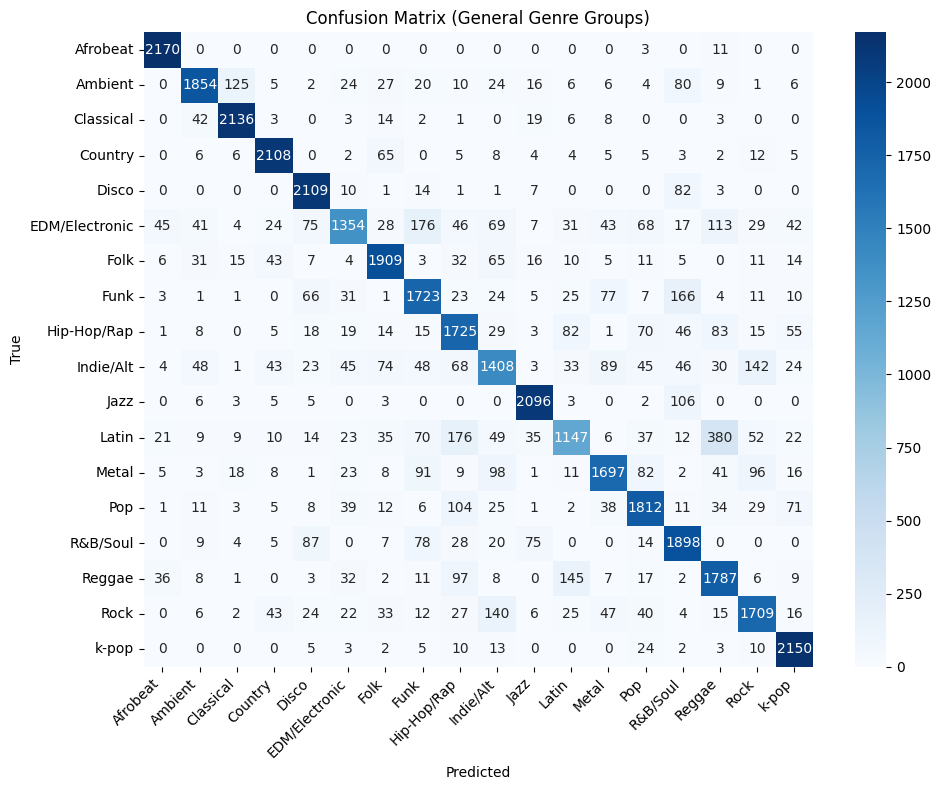

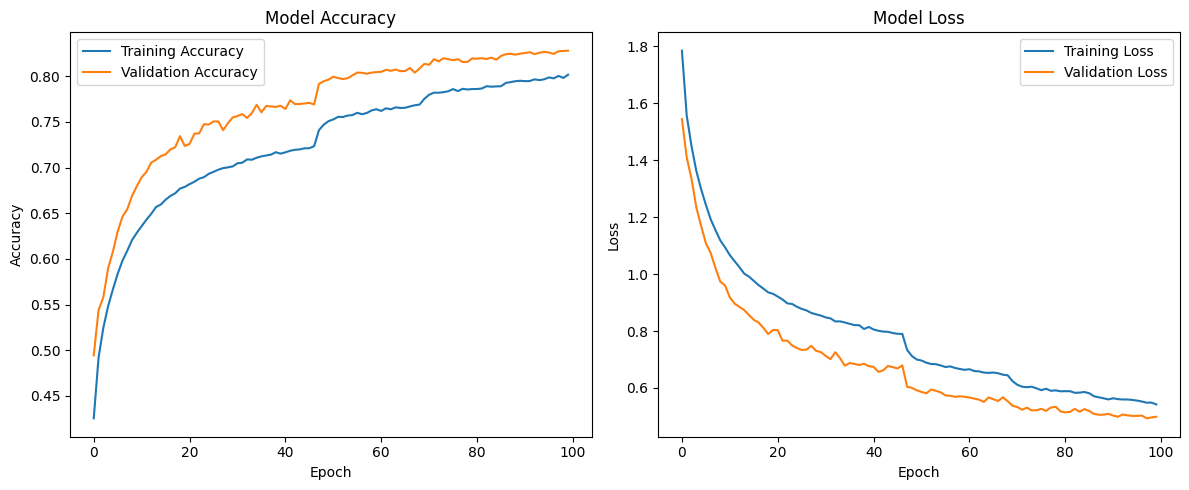

In [15]:
# Imports
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


# Ask to enter the path to the dataset file
data_path = Path(input("Enter path to your CSV file: ").strip())

# Verify that the file exists
if not data_path.is_file():
    raise FileNotFoundError(f"Could not find file at {data_path}")

# Load the dataset
df = pd.read_csv(data_path)
print("Dataset shape:", df.shape)
print("Dataset columns:", df.columns.tolist())

# Verify track_genre Column
if 'track_genre' not in df.columns:
    raise KeyError("The dataset must contain a 'track_genre' column.")


# Updated mapping dictionary that categorizes into 18 broad categories.
mapping = {
    # Afrobeat
    "afrobeat": "Afrobeat",

    # k-pop
    "k-pop": "k-pop",
    "kpop": "k-pop",  # in case it appears without the hyphen

    # Disco
    "disco": "Disco",

    # Jazz
    "jazz": "Jazz",

    # Country
    "country": "Country",
    "honky-tonk": "Country",

    # R&B/Soul
    "r&b": "R&B/Soul",
    "soul": "R&B/Soul",

    # Classical
    "classical": "Classical",
    "opera": "Classical",

    # Ambient
    "ambient": "Ambient",
    "chill": "Ambient",
    "sleep": "Ambient",

    # Folk
    "folk": "Folk",
    "bluegrass": "Folk",

    # Reggae
    "dub": "Reggae",
    "reggae": "Reggae",

    # Pop
    "pop": "Pop",
    "power-pop": "Pop",

    # Metal
    "black-metal": "Metal",
    "death-metal": "Metal",
    "heavy-metal": "Metal",
    "metal": "Metal",
    "metalcore": "Metal",

    # Rock
    "rock": "Rock",
    "punk": "Rock",
    "punk-rock": "Rock",

    # Hip-Hop/Rap
    "hip-hop": "Hip-Hop/Rap",
    "rap": "Hip-Hop/Rap",
    "trap": "Hip-Hop/Rap",
    "r-n-b": "Hip-Hop/Rap",

    # Funk
    "funk": "Funk",
    "groove": "Funk",

    # Indie/Alt
    "alt-rock": "Indie/Alt",
    "alternative": "Indie/Alt",
    "indie": "Indie/Alt",
    "indie-pop": "Indie/Alt",

    # EDM/Electronic
    "club": "EDM/Electronic",
    "dance": "EDM/Electronic",
    "deep-house": "EDM/Electronic",
    "detroit-techno": "EDM/Electronic",
    "edm": "EDM/Electronic",
    "electro": "EDM/Electronic",
    "electronic": "EDM/Electronic",
    "house": "EDM/Electronic",
    "minimal-techno": "EDM/Electronic",
    "techno": "EDM/Electronic",
    "trance": "EDM/Electronic",

    # Latin
    "brazil": "Latin",
    "forro": "Latin",
    "latin": "Latin",
    "latino": "Latin",
    "mpb": "Latin",
    "pagode": "Latin",
    "reggaeton": "Latin",
    "salsa": "Latin",
    "samba": "Latin"
}

# Standardize the 'track_genre' column to lowercase for consistency
df['track_genre'] = df['track_genre'].str.lower()

# Apply the updated mapping dictionary including possibly unmarked genres
df['broad_genre'] = df['track_genre'].map(mapping)
df['broad_genre'] = df['broad_genre'].fillna("Other") 

# Print broad genre counts for verification
print("Broad genre counts:")
print(df['broad_genre'].value_counts())

# Define features for classification
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'popularity']

# Ensure each feature exists in the dataset
for feature in features:
    if feature not in df.columns:
        raise KeyError(f"Feature column '{feature}' not found in dataset.")

# Drop rows with missing values in the specified feature columns
df = df.dropna(subset=features)

# Extract and Scale Features
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Replicate each sample's features to form a sequence.
T = 5  # The number of timesteps
# Replicate to (samples, T, features)
X_seq = np.tile(X_scaled[:, None, :], (1, T, 1))

# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['broad_genre'])
y_categorical = to_categorical(y_encoded)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_categorical, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

# Build the LSTM Model
num_features = X_train.shape[2]
num_classes = y_categorical.shape[1]
T = X_train.shape[1]

model = Sequential()
model.add(Input(shape=(T, num_features)))

# LSTM Architecture
model.add(Bidirectional(
    LSTM(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)
))

model.add(Bidirectional(
    LSTM(64, dropout=0.1, recurrent_dropout=0.1)
))

model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

opt = Adam(learning_rate=.002)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

# First, convert one-hot encoded labels back to integers
y_train_int = np.argmax(y_train, axis=1)

# Compute the balanced class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_int),
                                     y=y_train_int)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Recude LR on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       
    patience=5,       
    min_lr=1e-6,
    verbose=1
)

# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weight_dict,
    shuffle=True
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_accuracy))

# Obtain predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate metrics
acc = accuracy_score(y_true_labels, y_pred_labels)
prec = precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
rec = recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
cm = confusion_matrix(y_true_labels, y_pred_labels)

print("\nEvaluation Metrics:")
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(prec))
print("Recall: {:.4f}".format(rec))
print("F1-Score: {:.4f}".format(f1))

# Plot Confusion Matrix
genre_labels = label_encoder.classes_ 
print("Label order from LabelEncoder:", genre_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=genre_labels, yticklabels=genre_labels)
plt.title("Confusion Matrix (General Genre Groups)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot Training History
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Classification Performance Metrics

This cell uses scikit‑learn’s metrics to evaluate your model’s predictions:

1. **Per‑class F1 Scores**  
   Computes the F1 score for each genre individually (no averaging) to show how well the model balances precision and recall per class.

2. **Full Classification Report**  
   Displays precision, recall, F1‑score, and support for every class in a neatly formatted table.



In [16]:
from sklearn.metrics import f1_score, classification_report

# Compute per-class F1 scores (without averaging)
per_class_f1 = f1_score(y_true_labels, y_pred_labels, average=None)

print("Per-class F1 Scores:")
for i, score in enumerate(per_class_f1):
    print(f"Class {genre_labels[i]}: {score:.4f}")

# Alternatively, print a full classification report
print("\nFull Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=genre_labels))


Per-class F1 Scores:
Class Afrobeat: 0.9696
Class Ambient: 0.8619
Class Classical: 0.9358
Class Country: 0.9272
Class Disco: 0.9022
Class EDM/Electronic: 0.7041
Class Folk: 0.8634
Class Funk: 0.7740
Class Hip-Hop/Rap: 0.7581
Class Indie/Alt: 0.6777
Class Jazz: 0.9268
Class Latin: 0.6307
Class Metal: 0.8007
Class Pop: 0.8138
Class R&B/Soul: 0.8065
Class Reggae: 0.7622
Class Rock: 0.7960
Class k-pop: 0.9214

Full Classification Report:
                precision    recall  f1-score   support

      Afrobeat       0.95      0.99      0.97      2184
       Ambient       0.89      0.84      0.86      2219
     Classical       0.92      0.95      0.94      2237
       Country       0.91      0.94      0.93      2240
         Disco       0.86      0.95      0.90      2228
EDM/Electronic       0.83      0.61      0.70      2212
          Folk       0.85      0.87      0.86      2187
          Funk       0.76      0.79      0.77      2178
   Hip-Hop/Rap       0.73      0.79      0.76      2189
 

# Song Recommendation Interface

This function, `recommend_songs()`, guides the user through entering numerical song features, scales and formats them for LSTM input, and then:

1. Predicts the most likely genre using the trained model.  
2. Finds all songs in that genre and computes their Euclidean distance to the user’s input.  
3. Displays the top 3 closest matches by track name and artist.



In [ ]:
# User Input Recommendation
def recommend_songs():
    print("\nEnter the following song characteristics:")
    user_input = {}
    for feature in features:
        value = float(input(f"{feature.capitalize()}: "))
        user_input[feature] = value

    # Convert and scale
    user_df = pd.DataFrame([user_input])
    user_scaled = scaler.transform(user_df.values)

    # Replicate across T timesteps
    user_seq = np.tile(user_scaled[:, None, :], (1, T, 1))

    # Predict genre
    predicted_prob = model.predict(user_seq)
    predicted_class = np.argmax(predicted_prob)
    predicted_genre = label_encoder.inverse_transform([predicted_class])[0]

    print(f"\nPredicted Genre: {predicted_genre}")

    # Compute distance from input to all songs of the same predicted genre
    genre_df = df[df['broad_genre'] == predicted_genre].copy()
    genre_scaled = scaler.transform(genre_df[features].values)

    # Compute Euclidean distance
    distances = np.linalg.norm(genre_scaled - user_scaled, axis=1)
    genre_df['distance'] = distances

    # Sort and get top 3 closest songs
    top_matches = genre_df.sort_values('distance').head(3)

    print("\nTop 3 Similar Songs:")
    if {'track_name', 'artists'}.issubset(genre_df.columns):
        for idx, row in top_matches.iterrows():
            print(f"{row['track_name']} by {row['artists']}")
    else:
        print(top_matches[features + ['distance']])

recommend_songs()
